# Video pipeline with Yolo + Resnet Model

In [1]:
import os
import sys
from pprint import PrettyPrinter
import matplotlib.pyplot as plt
from typing import Dict, List
import numpy as np

pp = PrettyPrinter(indent=4)
from barazmoon.twitter import twitter_workload_generator

# get an absolute path to the directory that contains parent files
__file__ = globals()["_dh"][0]
project_dir = __file__ = globals()["_dh"][0]
sys.path.append(os.path.normpath(os.path.join(project_dir, "..", "..", "..")))

from experiments.utils.constants import FINAL_RESULTS_PATH
from experiments.utils.parser import AdaptationParser
from experiments.utils.drawing import draw_temporal, draw_cumulative
import experiments.utils.drawing

In [2]:
serieses = [600, 601, 602, 603, 604]
series_metadata = {
    600: {"label": "IPA"},
    601: {"label": "FA2-low"},
    602: {"label": "FA2-high"},
    603: {"label": "RIM-low"},
    604: {"label": "RIM-high"}
}
pipeline_name = "audio-sent"

series_paths = {
    series: os.path.join(FINAL_RESULTS_PATH, "series", str(series))
    for series in serieses
}

loaders = {
    series: AdaptationParser(
        series_path=series_path, model_name="video", type_of="router_pipeline"
    )
    for series, series_path in series_paths.items()
}

In [3]:
loaders

{600: <experiments.utils.parser.AdaptationParser at 0x7fe2a468fa90>,
 601: <experiments.utils.parser.AdaptationParser at 0x7fe2a468fd00>,
 602: <experiments.utils.parser.AdaptationParser at 0x7fe2a468faf0>,
 603: <experiments.utils.parser.AdaptationParser at 0x7fe3702e7880>,
 604: <experiments.utils.parser.AdaptationParser at 0x7fe2a43dc8e0>}

In [4]:
accuracy_methods = {}
adaptation_intervals = {}
simulation_modes = {}
configs = {}
for series, loader in loaders.items():
    configs_exp = loader.load_configs()
    print(f"series: {series} config:\n")
    config = configs_exp["0.yaml"]
    pp.pprint(config)
    configs[series] = config
    accuracy_methods[series] = config["accuracy_method"]
    adaptation_intervals[series] = config["adaptation_interval"]
    simulation_modes[series] = config["simulation_mode"]

series: 600 config:

{   'accuracy_method': 'sum',
    'adaptation_interval': 10,
    'allocation_mode': 'base',
    'alpha': 10,
    'backup_predictor_duration': 2,
    'backup_predictor_type': 'max',
    'baseline_mode': None,
    'batching_cap': 64,
    'benchmark_duration': 1,
    'beta': 0.5,
    'central_queue': True,
    'debug_mode': False,
    'distrpution_time': 30,
    'drop_limit': 20,
    'gamma': 10,
    'initial_active_model': [   'facebook-s2t-small-librispeech-asr',
                                'distilbert-base-uncased-finetuned-sst-2-english'],
    'initial_batch': [1, 1],
    'initial_cpu_allocation': [1, 1],
    'initial_replica': [1, 1],
    'latency_margin': 100,
    'logs_enabled': False,
    'metadata': 'bursty - ipa - cpu type: compute_cascadelake_r_ib',
    'mode': 'exponential',
    'model_name': ['audio', 'nlp-sent'],
    'monitoring_duration': 2,
    'nodes': [   {   'cpu_request': '1',
                     'data_type': 'audio',
                     'max

In [5]:
# load the sent workload
sent_loads = {}
for series, config in configs.items():
    workload_type = config["workload_type"]
    workload_config = config["workload_config"][0]
    start = workload_config["start"]
    end = workload_config["end"]
    damping_factor = workload_config["damping_factor"]
    sent_loads[series] = twitter_workload_generator(
        days=f"{start}-{end}", damping_factor=damping_factor
    )

In [6]:
# key_config_df = loader.loader.key_config_mapper()
# display(key_config_df)
# key_config_df.columns
results_all = []
simulation_modes

{600: False, 601: False, 602: False, 603: False, 604: False}

In [7]:
adaptation_logs = dict(
    map(lambda l: (l[0], l[1].load_adaptation_log()), loaders.items())
)

In [8]:
series_changes = {}
for series in serieses:
    series_changes[series] = loaders[series].series_changes(
        adaptation_log=adaptation_logs[series]
    )

## Comparing Predicted Load with the Recieved Load

[6, 5, 4, 5, 5, 5, 4, 5, 5, 5, 5, 5, 4, 5, 6, 6, 6, 4, 6, 5, 4, 5, 6, 5, 6, 5, 5, 4, 4, 7, 4, 3, 6, 5, 4, 4, 3, 6, 4, 6, 5, 4, 4, 6, 5, 6, 5, 5, 4, 5, 5, 4, 4, 6, 5, 3, 5, 5, 4, 5, 5, 7, 6, 6, 4, 5, 5, 4, 5, 4, 6, 6, 4, 6, 4, 5, 4, 4, 5, 5, 5, 5, 5, 5, 6, 4, 6, 6, 5, 5, 4, 5, 5, 4, 5, 4, 4, 6, 4, 6, 5, 6, 6, 7, 5, 5, 5, 5, 6, 4, 6, 4, 4, 5, 5, 6, 6, 3, 5, 5, 7, 4, 5, 4, 6, 5, 5, 5, 6, 6, 5, 5, 4, 4, 5, 5, 5, 5, 7, 6, 4, 4, 5, 4, 7, 7, 6, 5, 5, 4, 5, 5, 6, 6, 4, 4, 4, 4, 5, 5, 6, 5, 5, 5, 6, 4, 4, 5, 5, 5, 4, 4, 6, 5, 4, 5, 4, 5, 7, 5, 5, 5, 6, 6, 6, 5, 7, 5, 5, 5, 4, 5, 7, 4, 6, 5, 6, 6, 7, 5, 5, 6, 6, 4, 5, 4, 4, 5, 6, 5, 5, 5, 4, 5, 4, 6, 5, 7, 5, 7, 5, 5, 5, 5, 6, 4, 4, 5, 5, 4, 4, 6, 5, 4, 4, 5, 6, 6, 4, 3, 5, 3, 5, 5, 7, 5, 4, 5, 7, 5, 4, 4, 4, 4, 6, 4, 4, 6, 4, 3, 6, 5, 6, 5, 5, 4, 4, 6, 5, 4, 6, 5, 6, 5, 6, 7, 7, 5, 5, 4, 7, 6, 6, 5, 4, 6, 6, 4, 6, 5, 4, 4, 4, 5, 5, 5, 3, 5, 5, 6, 8, 10, 7, 6, 5, 6, 6, 5, 6, 6, 4, 6, 6, 3, 7, 6, 6, 4, 6, 6, 5, 6, 6, 3, 7, 4, 5, 6, 6, 5, 5, 5, 5,

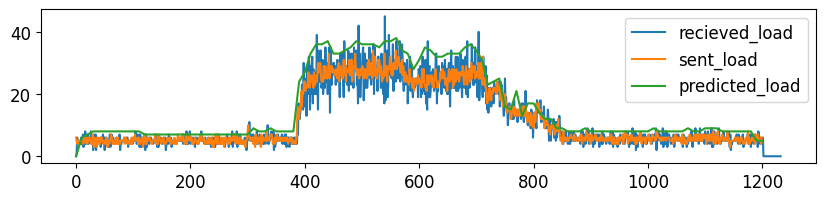

[6, 5, 4, 5, 5, 5, 4, 5, 5, 5, 5, 5, 4, 5, 6, 6, 6, 4, 6, 5, 4, 5, 6, 5, 6, 5, 5, 4, 4, 7, 4, 3, 6, 5, 4, 4, 3, 6, 4, 6, 5, 4, 4, 6, 5, 6, 5, 5, 4, 5, 5, 4, 4, 6, 5, 3, 5, 5, 4, 5, 5, 7, 6, 6, 4, 5, 5, 4, 5, 4, 6, 6, 4, 6, 4, 5, 4, 4, 5, 5, 5, 5, 5, 5, 6, 4, 6, 6, 5, 5, 4, 5, 5, 4, 5, 4, 4, 6, 4, 6, 5, 6, 6, 7, 5, 5, 5, 5, 6, 4, 6, 4, 4, 5, 5, 6, 6, 3, 5, 5, 7, 4, 5, 4, 6, 5, 5, 5, 6, 6, 5, 5, 4, 4, 5, 5, 5, 5, 7, 6, 4, 4, 5, 4, 7, 7, 6, 5, 5, 4, 5, 5, 6, 6, 4, 4, 4, 4, 5, 5, 6, 5, 5, 5, 6, 4, 4, 5, 5, 5, 4, 4, 6, 5, 4, 5, 4, 5, 7, 5, 5, 5, 6, 6, 6, 5, 7, 5, 5, 5, 4, 5, 7, 4, 6, 5, 6, 6, 7, 5, 5, 6, 6, 4, 5, 4, 4, 5, 6, 5, 5, 5, 4, 5, 4, 6, 5, 7, 5, 7, 5, 5, 5, 5, 6, 4, 4, 5, 5, 4, 4, 6, 5, 4, 4, 5, 6, 6, 4, 3, 5, 3, 5, 5, 7, 5, 4, 5, 7, 5, 4, 4, 4, 4, 6, 4, 4, 6, 4, 3, 6, 5, 6, 5, 5, 4, 4, 6, 5, 4, 6, 5, 6, 5, 6, 7, 7, 5, 5, 4, 7, 6, 6, 5, 4, 6, 6, 4, 6, 5, 4, 4, 4, 5, 5, 5, 3, 5, 5, 6, 8, 10, 7, 6, 5, 6, 6, 5, 6, 6, 4, 6, 6, 3, 7, 6, 6, 4, 6, 6, 5, 6, 6, 3, 7, 4, 5, 6, 6, 5, 5, 5, 5,

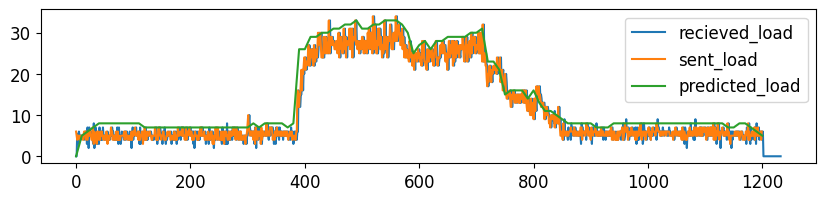

[6, 5, 4, 5, 5, 5, 4, 5, 5, 5, 5, 5, 4, 5, 6, 6, 6, 4, 6, 5, 4, 5, 6, 5, 6, 5, 5, 4, 4, 7, 4, 3, 6, 5, 4, 4, 3, 6, 4, 6, 5, 4, 4, 6, 5, 6, 5, 5, 4, 5, 5, 4, 4, 6, 5, 3, 5, 5, 4, 5, 5, 7, 6, 6, 4, 5, 5, 4, 5, 4, 6, 6, 4, 6, 4, 5, 4, 4, 5, 5, 5, 5, 5, 5, 6, 4, 6, 6, 5, 5, 4, 5, 5, 4, 5, 4, 4, 6, 4, 6, 5, 6, 6, 7, 5, 5, 5, 5, 6, 4, 6, 4, 4, 5, 5, 6, 6, 3, 5, 5, 7, 4, 5, 4, 6, 5, 5, 5, 6, 6, 5, 5, 4, 4, 5, 5, 5, 5, 7, 6, 4, 4, 5, 4, 7, 7, 6, 5, 5, 4, 5, 5, 6, 6, 4, 4, 4, 4, 5, 5, 6, 5, 5, 5, 6, 4, 4, 5, 5, 5, 4, 4, 6, 5, 4, 5, 4, 5, 7, 5, 5, 5, 6, 6, 6, 5, 7, 5, 5, 5, 4, 5, 7, 4, 6, 5, 6, 6, 7, 5, 5, 6, 6, 4, 5, 4, 4, 5, 6, 5, 5, 5, 4, 5, 4, 6, 5, 7, 5, 7, 5, 5, 5, 5, 6, 4, 4, 5, 5, 4, 4, 6, 5, 4, 4, 5, 6, 6, 4, 3, 5, 3, 5, 5, 7, 5, 4, 5, 7, 5, 4, 4, 4, 4, 6, 4, 4, 6, 4, 3, 6, 5, 6, 5, 5, 4, 4, 6, 5, 4, 6, 5, 6, 5, 6, 7, 7, 5, 5, 4, 7, 6, 6, 5, 4, 6, 6, 4, 6, 5, 4, 4, 4, 5, 5, 5, 3, 5, 5, 6, 8, 10, 7, 6, 5, 6, 6, 5, 6, 6, 4, 6, 6, 3, 7, 6, 6, 4, 6, 6, 5, 6, 6, 3, 7, 4, 5, 6, 6, 5, 5, 5, 5,

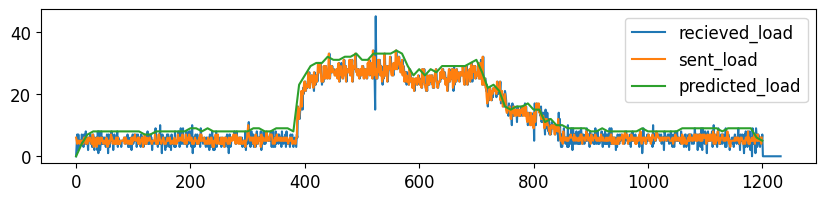

[6, 5, 4, 5, 5, 5, 4, 5, 5, 5, 5, 5, 4, 5, 6, 6, 6, 4, 6, 5, 4, 5, 6, 5, 6, 5, 5, 4, 4, 7, 4, 3, 6, 5, 4, 4, 3, 6, 4, 6, 5, 4, 4, 6, 5, 6, 5, 5, 4, 5, 5, 4, 4, 6, 5, 3, 5, 5, 4, 5, 5, 7, 6, 6, 4, 5, 5, 4, 5, 4, 6, 6, 4, 6, 4, 5, 4, 4, 5, 5, 5, 5, 5, 5, 6, 4, 6, 6, 5, 5, 4, 5, 5, 4, 5, 4, 4, 6, 4, 6, 5, 6, 6, 7, 5, 5, 5, 5, 6, 4, 6, 4, 4, 5, 5, 6, 6, 3, 5, 5, 7, 4, 5, 4, 6, 5, 5, 5, 6, 6, 5, 5, 4, 4, 5, 5, 5, 5, 7, 6, 4, 4, 5, 4, 7, 7, 6, 5, 5, 4, 5, 5, 6, 6, 4, 4, 4, 4, 5, 5, 6, 5, 5, 5, 6, 4, 4, 5, 5, 5, 4, 4, 6, 5, 4, 5, 4, 5, 7, 5, 5, 5, 6, 6, 6, 5, 7, 5, 5, 5, 4, 5, 7, 4, 6, 5, 6, 6, 7, 5, 5, 6, 6, 4, 5, 4, 4, 5, 6, 5, 5, 5, 4, 5, 4, 6, 5, 7, 5, 7, 5, 5, 5, 5, 6, 4, 4, 5, 5, 4, 4, 6, 5, 4, 4, 5, 6, 6, 4, 3, 5, 3, 5, 5, 7, 5, 4, 5, 7, 5, 4, 4, 4, 4, 6, 4, 4, 6, 4, 3, 6, 5, 6, 5, 5, 4, 4, 6, 5, 4, 6, 5, 6, 5, 6, 7, 7, 5, 5, 4, 7, 6, 6, 5, 4, 6, 6, 4, 6, 5, 4, 4, 4, 5, 5, 5, 3, 5, 5, 6, 8, 10, 7, 6, 5, 6, 6, 5, 6, 6, 4, 6, 6, 3, 7, 6, 6, 4, 6, 6, 5, 6, 6, 3, 7, 4, 5, 6, 6, 5, 5, 5, 5,

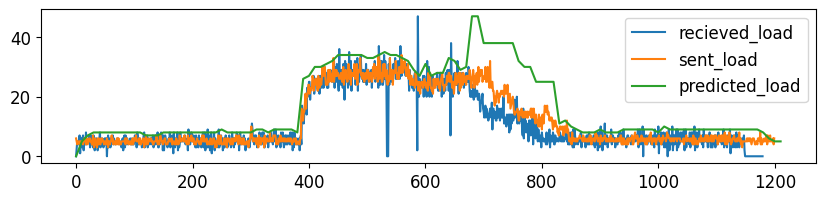

[6, 5, 4, 5, 5, 5, 4, 5, 5, 5, 5, 5, 4, 5, 6, 6, 6, 4, 6, 5, 4, 5, 6, 5, 6, 5, 5, 4, 4, 7, 4, 3, 6, 5, 4, 4, 3, 6, 4, 6, 5, 4, 4, 6, 5, 6, 5, 5, 4, 5, 5, 4, 4, 6, 5, 3, 5, 5, 4, 5, 5, 7, 6, 6, 4, 5, 5, 4, 5, 4, 6, 6, 4, 6, 4, 5, 4, 4, 5, 5, 5, 5, 5, 5, 6, 4, 6, 6, 5, 5, 4, 5, 5, 4, 5, 4, 4, 6, 4, 6, 5, 6, 6, 7, 5, 5, 5, 5, 6, 4, 6, 4, 4, 5, 5, 6, 6, 3, 5, 5, 7, 4, 5, 4, 6, 5, 5, 5, 6, 6, 5, 5, 4, 4, 5, 5, 5, 5, 7, 6, 4, 4, 5, 4, 7, 7, 6, 5, 5, 4, 5, 5, 6, 6, 4, 4, 4, 4, 5, 5, 6, 5, 5, 5, 6, 4, 4, 5, 5, 5, 4, 4, 6, 5, 4, 5, 4, 5, 7, 5, 5, 5, 6, 6, 6, 5, 7, 5, 5, 5, 4, 5, 7, 4, 6, 5, 6, 6, 7, 5, 5, 6, 6, 4, 5, 4, 4, 5, 6, 5, 5, 5, 4, 5, 4, 6, 5, 7, 5, 7, 5, 5, 5, 5, 6, 4, 4, 5, 5, 4, 4, 6, 5, 4, 4, 5, 6, 6, 4, 3, 5, 3, 5, 5, 7, 5, 4, 5, 7, 5, 4, 4, 4, 4, 6, 4, 4, 6, 4, 3, 6, 5, 6, 5, 5, 4, 4, 6, 5, 4, 6, 5, 6, 5, 6, 7, 7, 5, 5, 4, 7, 6, 6, 5, 4, 6, 6, 4, 6, 5, 4, 4, 4, 5, 5, 5, 3, 5, 5, 6, 8, 10, 7, 6, 5, 6, 6, 5, 6, 6, 4, 6, 6, 3, 7, 6, 6, 4, 6, 6, 5, 6, 6, 3, 7, 4, 5, 6, 6, 5, 5, 5, 5,

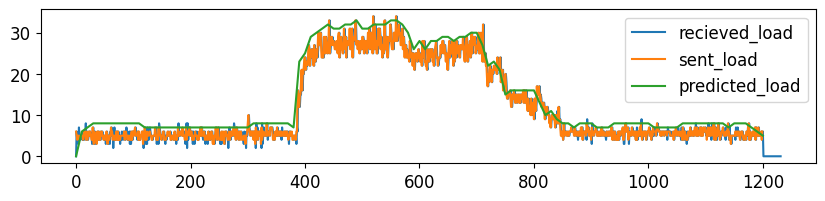

In [9]:
for series, series_dict in series_changes.items():
    recieved_load = series_changes[series]["recieved_load"]
    predicted_load = series_changes[series]["predicted_load"]
    # recieved_load = [int(item) for item in recieved_load if item != 0]
    recieved_load_x = [x for x in range(0, len(recieved_load))]
    sent_load_x = [x for x in range(0, len(sent_loads[series]))]
    predicted_load_x = series_changes[series]["time_interval"]

    print(sent_loads[series])
    print(recieved_load)

    print(len(sent_loads[series]))
    print(len(recieved_load))
    plt.figure(figsize=(10, 2))
    plt.plot(recieved_load_x, recieved_load, label="recieved_load")
    plt.plot(sent_load_x, sent_loads[series], label="sent_load")
    plt.plot(predicted_load_x, predicted_load, label="predicted_load")
    # TODO add predicted reference load here
    plt.legend()
    plt.show()


## Replica Changes
1. Total
2. Per node

In [10]:
replica_changes = {}
for series, series_dict in series_changes.items():
    # print(50 * "-" + f" {series} " + 50 * "-")
    replica_changes[series] = {}
    nodes = []
    for node_name, metrics in series_changes[series]["nodes"].items():
        replica_changes[series][node_name] = metrics["replicas"]
        nodes.append(node_name)
    # replica_changes['total'] = []
    replica_changes[series]["total"] = [
        sum(x) for x in zip(*replica_changes[series].values())
    ]

## Per Container Core changes
1. Total
2. Per Node

In [11]:
core_changes = {}
for series in serieses:
    # print(50 * "-" + f" {series} " + 50 * "-")
    core_changes[series] = {}
    nodes = []
    for node_name, metrics in series_changes[series]["nodes"].items():
        core_changes[series][node_name] = metrics["cpu"]
        nodes.append(node_name)
    core_changes[series]["total"] = [
        sum(x) for x in zip(*core_changes[series].values())
    ]

## Total core changes
replica * cores for each stage
1. Total
2. Per Node

In [12]:
total_core_changes = {}
for series in serieses:
    # print(50 * "-" + f" {series} " + 50 * "-")
    total_core_changes[series] = {}
    for key in replica_changes[series].keys():
        if key != "total":
            total_core_changes[series][key] = [
                x * y
                for x, y in zip(replica_changes[series][key], core_changes[series][key])
            ]
    total = np.zeros(len(list(total_core_changes[series].values())[0]))
    for key, series_value in total_core_changes[series].items():
        total += np.array(series_value)
    total_core_changes[series]["total"] = total.tolist()
    # draw_temporal(total_core_changes[series])
ylabel = "Total Core"
print(total_core_changes)
print(total_core_changes.keys())
# print(total_core_changes[221].keys())

{600: {'audio': [1, 12, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 16, 14, 14, 16, 14, 14, 14, 14, 16, 18, 22, 24, 24, 25, 22, 22, 23, 23, 25, 24, 24, 24, 23, 25, 25, 25, 23, 22, 19, 21, 23, 23, 21, 21, 22, 22, 22, 23, 24, 23, 21, 15, 16, 17, 11, 10, 14, 9, 12, 12, 10, 8, 8, 16, 16, 14, 14, 14, 16, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 16, 14, 14, 14, 14, 14, 16, 14, 14, 16, 16, 16, 14, 14, 14, 14, 14, 14, 14, 14], 'nlp-sent': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'total': [2.0, 13.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15

## Accuracy Changes

In [13]:
accuracy_changes = {}
for series in serieses:
    accuracy_changes[series] = {}
    # print(50 * "-" + f" {series} " + 50 * "-")
    nodes = []
    for node_name, metrics in series_changes[series]["nodes"].items():
        accuracy_changes[series][node_name] = metrics["accuracy"]
        nodes.append(node_name)
    # replica_changes['total'] = []
    if accuracy_methods[series] == "sum":
        accuracy_changes[series]["e2e"] = [
            sum(x) for x in zip(*accuracy_changes[series].values())
        ]
ylabel = "Accuracy"
print(accuracy_changes)
print(accuracy_changes.keys())
# print(accuracy_changes[221].keys())

{600: {'audio': [0.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5], 'nlp-sent': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

## Maeseured p99 Latency


In [14]:
timeout_per_second = {}
per_second_results = {}
for series in serieses:
    if not simulation_modes[series]:
        timeout_per_second[series], per_second_results[series] = loaders[
            series
        ].per_second_result_processing()
    else:
        timeout_per_second[series], per_second_results[series] = None, None

In [15]:
metric = "p99"  # [min, max, p99]
metrics_all = {}
for series in serieses:
    # print(50 * "-" + f" {series} " + 50 * "-")
    if not simulation_modes[series]:
        metric_columns = list(
            filter(lambda col: metric in col, per_second_results[series].columns)
        )
        metrics_all[series] = per_second_results[series][metric_columns]
        # metrics_all[series][f"{metric}_e2e"] = metrics_all[series].sum(axis=1).to_list()
        metrics_all[series] = metrics_all[series].to_dict(orient="list")
        # draw_temporal(metrics_all[series])
ylabel = "Second"
print(metrics_all)
print(metrics_all.keys())
# print(metrics_all[221].keys())

{600: {'client_to_router_p99': [0.014760005474090577, 0.00972269058227539, 0.00749636173248291, 0.009429998397827148, 0.008222074508666992, 0.01060044288635254, 0.010503664016723632, 0.009174818992614747, 0.013142309188842773, 0.008697500228881836, 0.012416954040527345, 0.008421146869659423, 0.011045246124267579, 0.01215207815170288, 0.009900083541870117, 0.01201392412185669, 0.010793209075927734, 0.008944141864776612, 0.012102746963500976, 0.008713874816894531, 0.009388341903686523, 0.017978296279907227, 0.007641899585723877, 0.009189233779907227, 0.008994758129119873, 0.009140615463256835, 0.009273977279663085, 0.008064680099487305, 0.00819916009902954, 0.00868129253387451, 0.00843238353729248, 0.008270535469055176, 0.008780622482299804, 0.009539947509765626, 0.009378194808959961, 0.007507209777832031, 0.008625345230102539, 0.00851426124572754, 0.007998931407928466, 0.009083902835845948, 0.008623981475830078, 0.008718302249908447, 0.014787263870239256, 0.009726226329803467, 0.0107530

## timeouts

In [16]:
ylabel = "% SLA Violations"
xlabel = "Experiments"
timeout_dics = {}
for series in serieses:
    if not simulation_modes[series]:
        timeout_dics[series] = {
            "e2e": (
                np.array(timeout_per_second[series]) / sum(sent_loads[series])
            ).tolist()
        }
        # draw_temporal(timeout_dics[series])
        print(f"{sum(timeout_per_second[series])} out of {sum(sent_loads[series])}")

print(timeout_dics)
print(timeout_dics.keys())
# print(timeout_dics[221].keys())


183 out of 14437
0 out of 14437
26 out of 14437
9597 out of 14437
0 out of 14437
{600: {'e2e': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

# Paper ready figures

In [17]:
import importlib
import math


METRIC_TOTAL_CORE_CHANGES = "cost"
METRIC_ACCURACY_CHANGES = "accuracy"
METRIC_MEASURED_LATENCY = "latency"
# METRIC_TIMEOUT_DICS = "sla_violation"


metrics_metadata = {
    METRIC_TOTAL_CORE_CHANGES: {
        "title": "Cost",
        "ylabel": "Cost (cores)",
    },
    METRIC_ACCURACY_CHANGES: {
        "title": "Accuracy",
        "ylabel": "Accuracy",
    },
    METRIC_MEASURED_LATENCY: {
        "title": "Latency",
        "ylabel": "Latency (s)",
    },
    # METRIC_TIMEOUT_DICS: {
    #     "title": "SLA Violations",
    #     "ylabel": "SLA Violations (%)",
    # },
}
results = {
    METRIC_MEASURED_LATENCY: {},
    # METRIC_TIMEOUT_DICS: {},
    METRIC_TOTAL_CORE_CHANGES: {},
    METRIC_ACCURACY_CHANGES: {}}

# for serie in timeout_dics.keys():
#     sla_violations = list(filter(lambda x: x is not None and not math.isnan(x), timeout_dics[serie]["e2e"]))
#     results[METRIC_TIMEOUT_DICS][serie] = sum(sla_violations)/len(sla_violations)  # Fixme: Is this correct?

for serie in metrics_all.keys():
    latencies = list(filter(lambda x: x is not None and not math.isnan(x), metrics_all[serie]["e2e_p99"]))
    results[METRIC_MEASURED_LATENCY][serie] = sum(latencies)/len(latencies)

for serie in accuracy_changes.keys():
    results[METRIC_ACCURACY_CHANGES][serie] = sum(accuracy_changes[serie]["e2e"])/len(accuracy_changes[serie]["e2e"])

for serie in total_core_changes.keys():
    results[METRIC_TOTAL_CORE_CHANGES][serie] = sum(total_core_changes[serie]["total"])/len(total_core_changes[serie]["total"])
    

print(results)

{'latency': {600: 1.596084007275103, 601: 0.8381704860726993, 602: 2.7860578898628554, 603: 1.572537152033358, 604: 0.6667991006533304}, 'cost': {600: 18.082644628099175, 601: 11.776859504132231, 602: 28.115702479338843, 603: 16.80327868852459, 604: 25.0}, 'accuracy': {600: 1.3099173553719008, 601: 1.0, 602: 1.5, 603: 1.4877049180327868, 604: 1.0}}


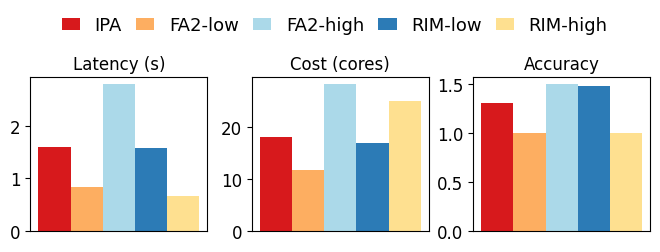

In [18]:
importlib.reload(experiments.utils.drawing)

experiments.utils.drawing.draw_cumulative_final(
    results,
    series_metadata,
    metrics_metadata,
    f"{pipeline_name}-cul"
)